In this notebook, we will learn how to fool a pre-trained ResNet50 model by launching a simple PGD-based attack (Projected Gradient Descent).

## Initial setup and imports

In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.3.0


We first download a sample image which we will perturb in order to fool our pre-trained image classifier. We also download a dictionary that contains the mapping between the Imagenet dataset class labels and their ids (the ResNet50 model is pre-trained on ImageNet). 

In [2]:
!wget -q https://adversarial-ml-tutorial.org/introduction/pig.jpg
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

## A few early constants

In [3]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

## Utility functions

Next we define a couple of utility functions that we will be using throughout the course of this notebook. 

In [4]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels, preprocess=False):
    if preprocess:
        image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

## Loading our first image and pre-trained model

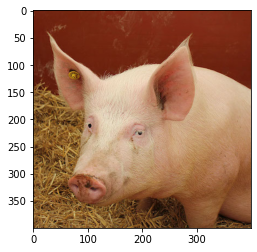

102973440/102967424 [==============================] - 0s 0us/step


In [5]:
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

## Running inference with a pre-trained model

In [6]:
preds = resnet50.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02395406', 'hog', 0.99968374), ('n02396427', 'wild_boar', 0.00031595054), ('n03935335', 'piggy_bank', 9.8273716e-08)]
Class idx: 341


Now, just as a sanity check, a model having a very confidence about its prediction in this case should have a very low cross-entropy loss. Let's verify that. Also, if trace back the loss we should get the exact top-1 confidence we got above. 

In [7]:
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    tf.convert_to_tensor([preds.argmax()]),
    tf.convert_to_tensor(preds)
)
print("Cross-entropy loss", loss.numpy())
print("Top-1 confidence", np.exp(-loss.numpy()))

Cross-entropy loss 0.0004157156
Top-1 confidence 0.9995844


Let's now write our utility functions for launching a simple PGD-based attack. 

## Utility functions for adversarial attacks

In this attack we will use PGD to simply increase the loss for the given class such that the visual semantics of our input image does not get hampered. 

In [8]:
def generate_adversaries(image_tensor, delta, model, true_class_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    for t in range(50):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            loss = - scc_loss(
                    tf.convert_to_tensor([true_class_index]),
                    predictions
                )
            if t % 5 == 0:
                print(t, loss.numpy())
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image_path, true_class_index, model):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocess_input(preprocessed_image))
    print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries(image_tensor, delta, model, true_class_index)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = model.predict(perturbed_image)
    print("Prediction after adv.:", decode_predictions(preds, top=3)[0])

**Note** that the hyperparameters like learning rate, number of epochs were determined after empirical experiments and also by referring to [this tremendous tutorial](https://adversarial-ml-tutorial.org/introduction/). 

## Launching a simple attack!

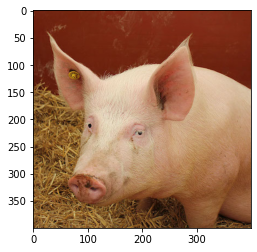

Prediction before adv.: [('n02395406', 'hog', 0.99968874), ('n02396427', 'wild_boar', 0.0003111297), ('n03935335', 'piggy_bank', 8.920516e-08)]
0 -0.00041094917
5 -0.0010640918
10 -0.0053317016
15 -0.063214585
20 -0.76871
25 -3.4471185
30 -7.393548
35 -13.130766
40 -16.118187
45 -16.11819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


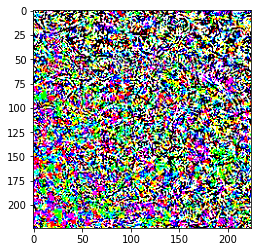

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


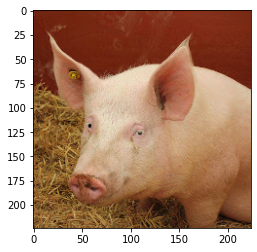

Prediction after adv.: [('n01883070', 'wombat', 0.9999813), ('n02909870', 'bucket', 1.1373292e-05), ('n02454379', 'armadillo', 1.8905822e-06)]


In [9]:
perturb_image("pig.jpg", 341, resnet50)

The model now thinks that this is a `wombat` with 99% confidence. 